In [ ]:
!pip install tensorflow matplotlib numpy scikit-learn --user -U

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

print(tf.__version__) # verifica veloce versione TF


2.13.0


In [3]:
# Carica CIFAR-10: (X_train, y_train), (X_test, y_test)
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()
y_train_full = y_train_full.flatten()
y_test_full = y_test_full.flatten()

# CIFAR-10 label map ufficiale
label_names = ['airplane', 'automobile', 'bird','cat','deer' ,'dog','frog','horse', 'ship', 'truck']
cat_label, dog_label = 3, 5

# Filtra solo gatti e cani
train_mask = (y_train_full == cat_label) | (y_train_full == dog_label)
test_mask = (y_test_full == cat_label) | (y_test_full == dog_label)

X_train_cd = X_train_full[train_mask]
y_train_cd = y_train_full[train_mask]
X_test_cd = X_test_full[test_mask]
y_test_cd = y_test_full[test_mask]

# Rimappa etichette: cat->0, dog->1
y_train_cd = (y_train_cd == dog_label).astype(np.int32)
y_test_cd = (y_test_cd == dog_label).astype(np.int32)

X_train_cd.shape, X_test_cd.shape, np.bincount(y_train_cd), np.bincount(y_test_cd)

170498071/170498071 [==============================] - 8s 0us/step


((10000, 32, 32, 3),
 (2000, 32, 32, 3),
 array([5000, 5000], dtype=int64),
 array([1000, 1000], dtype=int64))

In [28]:
def show_examples(x, y, class_names=('cat', 'dog'), n=12):
    plt.figure(figsize=(10, 4))
    idx = np.random.choice(len(x), size=n, replace=False)
    for i, j in enumerate(idx):
        plt.subplot(2, n//2, i+1)
        plt.imshow(x[j])
        plt.title(class_names[y[j]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [17]:
# Opzione: riduci il numero di campioni per velocizzare il training in aula
# Imposta a None per usare tutti i dati disponibili
SAMPLES_PER_CLASS_TRAIN = 3000 # es: 3000 cat + 3000 dog = 6000
SAMPLES_PER_CLASS_TEST = 500

def subsample_balanced(X, y, samples_per_class) :
    if samples_per_class is None:
        return X, y
    X_out, y_out = [], []
    for cls in [0,1]:
        idx = np.where(y == cls) [0]
        idx = np.random.choice(idx, size=min(samples_per_class, len(idx) ), replace=False)
        X_out.append(X[idx])
        y_out.append(y[idx] )
    return np.concatenate(X_out), np.concatenate(y_out)

X_train_small, y_train_small = subsample_balanced(X_train_cd, y_train_cd, SAMPLES_PER_CLASS_TRAIN)
X_test_small, y_test_small = subsample_balanced(X_test_cd, y_test_cd, SAMPLES_PER_CLASS_TEST)

# Mescola il training
perm = np. random. permutation(len(X_train_small) )
X_train_small, y_train_small = X_train_small[perm], y_train_small[perm]

# Normalizzazione [0,1]
X_train_small = X_train_small.astype('float32') / 255.0
X_test_small = X_test_small.astype('float32') / 255.0

X_train_small.shape, X_test_small.shape

((6000, 32, 32, 3), (1000, 32, 32, 3))

In [25]:
def build_cnn(input_shape=(32,32,3)):
    model = models. Sequential( [
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers. Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid') # output binario
    ])
    model. compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn()
model. summary ()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

In [29]:
EPOCHS = 4
history = model.fit(
    X_train_small, y_train_small,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=64,
    verbose=1
)

Epoch 1/4
85/85 [==============================] - 7s 64ms/step - loss: 0.6900 - accuracy: 0.5319 - val_loss: 0.6821 - val_accuracy: 0.5800
Epoch 2/4
85/85 [==============================] - 5s 64ms/step - loss: 0.6466 - accuracy: 0.6246 - val_loss: 0.6284 - val_accuracy: 0.6450
Epoch 3/4
85/85 [==============================] - 7s 77ms/step - loss: 0.5954 - accuracy: 0.6891 - val_loss: 0.6120 - val_accuracy: 0.6433
Epoch 4/4
85/85 [==============================] - 5s 61ms/step - loss: 0.5493 - accuracy: 0.7211 - val_loss: 0.5532 - val_accuracy: 0.7200


In [32]:
# Valutazione su test
y_prob = model.predict(X_test_small). ravel()
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_test_small, y_pred)
cm = confusion_matrix(y_test_small, y_pred)

print(f"Accuracy test: {acc:.3f}")
print("Confusion Matrix (rows=veri, cols=predetti):\n", cm)
print("\nReport:\n", classification_report(y_test_small, y_pred, target_names=['cat','dog'] ) )

32/32 [==============================] - 0s 8ms/step
Accuracy test: 0.740
Confusion Matrix (rows=veri, cols=predetti):
 [[365 135]
 [125 375]]

Report:
               precision    recall  f1-score   support

         cat       0.74      0.73      0.74       500
         dog       0.74      0.75      0.74       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



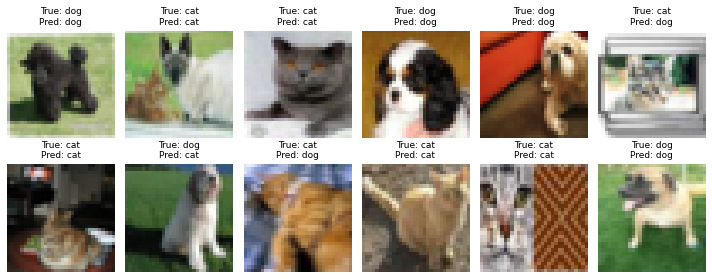

In [33]:
def show_predictions(X, y_true, y_hat, n=12):
    plt.figure(figsize=(10, 4))
    idx = np. random. choice(len(X), size=n, replace=False)
    for i, j in enumerate(idx):
        plt.subplot(2, n//2, i+1)
        plt.imshow(X[j])
        title = f"True: {'dog' if y_true[j] == 1 else 'cat'}\nPred: {'dog' if y_hat[j] == 1 else 'cat'}"
        plt.title(title, fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Attenzione: X_test_small era normalizzato (float in [0,1]), per visualizzare manteniamo così
show_predictions(X_test_small, y_test_small, y_pred, n=12)